<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли" data-toc-modified-id="Расчёт-прибыли-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Расчёт прибыли</a></span></li><li><span><a href="#Расчёт-рисков" data-toc-modified-id="Расчёт-рисков-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Расчёт рисков</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#P.S.-Риск-равен-0?" data-toc-modified-id="P.S.-Риск-равен-0?-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>P.S. Риск равен 0?</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Выбор локации для скважины

## Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Условия задачи:
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from numpy.random import RandomState

In [2]:
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [3]:
def review(data, i):
    print('Регион',i)
    display(data.head(3))
    display(data.describe())
    display(data.info())
    columns = ['f0','f1','f2','product']
    for c in columns:
        data[c].plot.box(vert=False, figsize=(6, 0.5))
        plt.show()

Регион 0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

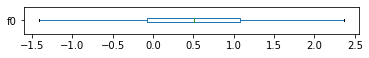

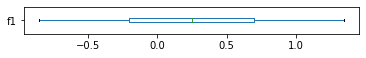

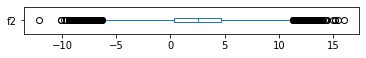

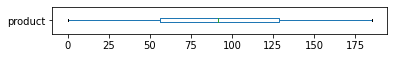

In [4]:
review(data_0, 0)

Регион 1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

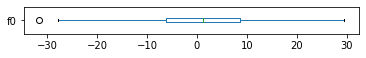

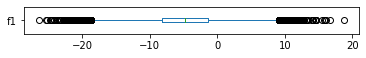

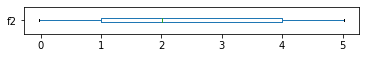

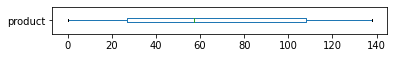

In [5]:
review(data_1, 1)

Регион 2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

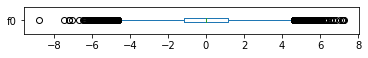

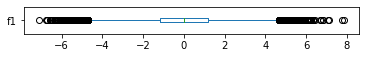

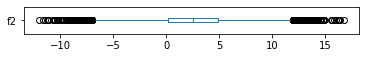

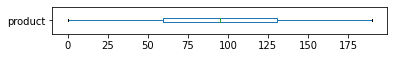

In [6]:
review(data_2, 2)

Данные без пропусков и выбросов. 

In [7]:
print(data_0.duplicated().sum())
print(data_1.duplicated().sum())
print(data_2.duplicated().sum())

0
0
0


Явных дубликатов нет

In [8]:
print(data_0['id'].duplicated().sum())
print(data_1['id'].duplicated().sum())
print(data_2['id'].duplicated().sum())

10
4
4


Есть несколько записей с одинаковыми id скважин. Непонятно какой из вариантов считать верным.  
Так как количество таких записей ничтожно мало, можно их удалить.

In [9]:
data_0.drop(data_0[data_0['id'].duplicated()].index, inplace=True)
data_1.drop(data_1[data_1['id'].duplicated()].index, inplace=True)
data_2.drop(data_2[data_2['id'].duplicated()].index, inplace=True)
print(data_0['id'].duplicated().sum())
print(data_1['id'].duplicated().sum())
print(data_2['id'].duplicated().sum())

0
0
0


In [10]:
data_0.corr().style.background_gradient(cmap='coolwarm',axis=0)  

,f0,f1,f2,product
f0,1.000000,-0.440717,-0.003211,0.143504
f1,-0.440717,1.000000,0.001764,-0.192351
f2,-0.003211,0.001764,1.000000,0.483631
product,0.143504,-0.192351,0.483631,1.000000


In [11]:
data_1.corr().style.background_gradient(cmap='coolwarm',axis=0)  

,f0,f1,f2,product
f0,1.000000,0.182279,-0.001810,-0.030523
f1,0.182279,1.000000,-0.002594,-0.010154
f2,-0.001810,-0.002594,1.000000,0.999397
product,-0.030523,-0.010154,0.999397,1.000000


In [12]:
data_2.corr().style.background_gradient(cmap='coolwarm',axis=0)  

,f0,f1,f2,product
f0,1.000000,0.000506,-0.000452,-0.001978
f1,0.000506,1.000000,0.000753,-0.001055
f2,-0.000452,0.000753,1.000000,0.445867
product,-0.001978,-0.001055,0.445867,1.000000


Параметр f2 сильно коррелирует с целевым признаком.   
А в регионе 1 корреляция почти 100%. Это позволит получить очень точные предсказания для этого региона. 

Теперь разделим данные на выборки

In [13]:
target_0 = data_0['product']
features_0 = data_0[['f0','f1','f2']]
target_1 = data_1['product']
features_1 = data_1[['f0','f1','f2']]
target_2 = data_2['product']
features_2 = data_2[['f0','f1','f2']]

In [14]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=12345)
print('0:',features_train_0.shape, features_valid_0.shape, target_train_0.shape, target_valid_0.shape)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345)
print('1:',features_train_1.shape, features_valid_1.shape, target_train_1.shape, target_valid_1.shape)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=12345)
print('2:',features_train_2.shape, features_valid_2.shape, target_train_2.shape, target_valid_2.shape)

0: (74992, 3) (24998, 3) (74992,) (24998,)
1: (74997, 3) (24999, 3) (74997,) (24999,)
2: (74997, 3) (24999, 3) (74997,) (24999,)


Так как значения параметров `f0, f1, f2` одного порядка, масштабировать данные не нужно.

## Обучение и проверка модели

In [15]:
model_0 = LinearRegression()
model_0.fit(features_train_0, target_train_0)
predicted_valid_0 = model_0.predict(features_valid_0)
r2_0 = r2_score(target_valid_0, predicted_valid_0)
mae_0 = mean_absolute_error(target_valid_0, predicted_valid_0)
rmse_0 = mean_squared_error(target_valid_0, predicted_valid_0) ** 0.5
pvm_0 = predicted_valid_0.mean()
print('R2 0:', r2_0)
print('MAE 0:', mae_0)
print('RMS 1:', rmse_0)
print('Predicted values mean:', pvm_0)

R2 0: 0.2723923460817068
MAE 0: 31.141028675220266
RMS 1: 37.853527328872964
Predicted values mean: 92.78915638280621


In [16]:
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)
predicted_valid_1 = model_1.predict(features_valid_1)
r2_1 = r2_score(target_valid_1, predicted_valid_1)
mae_1 = mean_absolute_error(target_valid_1, predicted_valid_1)
rmse_1 = mean_squared_error(target_valid_1, predicted_valid_1) ** 0.5
pvm_1 = predicted_valid_1.mean()
print('R2 1:', r2_1)
print('MAE 1:', mae_1)
print('RMS 1:', rmse_1)
print('Predicted values mean:', pvm_1)

R2 1: 0.9996222988190184
MAE 1: 0.7193530096516099
RMS 1: 0.892059264771703
Predicted values mean: 69.17831957030432


In [17]:
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)
predicted_valid_2 = model_2.predict(features_valid_2)
r2_2 = r2_score(target_valid_2, predicted_valid_2)
mae_2 = mean_absolute_error(target_valid_2, predicted_valid_2)
rmse_2 = mean_squared_error(target_valid_2, predicted_valid_2) ** 0.5
pvm_2 = predicted_valid_2.mean()
print('R2 2:', r2_2)
print('MAE 2:', mae_2)
print('RMS 1:', rmse_2)
print('Predicted values mean:', pvm_2)

R2 2: 0.19556241810202346
MAE 2: 32.83139014902301
RMS 1: 40.07585073246016
Predicted values mean: 94.86572480562035


Как и ожидалось, из-за сильной корреляции целевого параметра с признаком f2 в регионе 1 модель получила очень хорошие показатели: R2 = 0.9996  
В регионе 0 и 2 показатели значительно хуже: R2 = 0.272, R2 = 0.196 соответственно.

Однако среднее количество сырья в первом регионе наименьшее: всего 69.2.   
В регионе 0 и 2 среднее значение значительно выше и почти одинаковое: 92.8 и 94.5 соответственно.

## Подготовка к расчёту прибыли

In [18]:
# бюджет на регион
budget = 10 ** 10
# количество скважин для разработки
dev_wells = 200
# цена разработки одной скважины 
#считаю что стоимость взятия проб очень низкая по сравнению с разработкой
one_well_cost = budget / dev_wells
# количеств скважин для взятия проб
samp_wells = 500 
# цена за тысячу баррелей
barrel_cost = 450000

Вычислим достаточный объём сырья для безубыточной разработки новой скважины:  
product > 111,(1)

In [19]:
profit_threshold = one_well_cost / barrel_cost
profit_threshold

111.11111111111111

In [21]:
print('Среднее количество запасов в каждом регионе:')
print('0:', data_0['product'].mean())
print('1:', data_1['product'].mean())
print('2:', data_2['product'].mean())

Среднее количество запасов в каждом регионе:
0: 92.49968421774354
1: 68.82391591804064
2: 94.99834211933378


Среднее значение во всех регионах ниже порога прибыльности.


## Расчёт прибыли

Чтобы автоматизировать процесс, сохраню значения target в массив.

In [22]:
target_valid = [target_valid_0, target_valid_1, target_valid_2]

Теперь можно переписать подсчёт прибыли.

In [23]:
def calculate_profit(wells, region):
    profit = (target_valid[region][wells.index]*barrel_cost-one_well_cost).sum()
    return profit

Приведём предсказания к типу Series и восстановим изначальные индексы

In [24]:
ser_pred_0 = pd.Series(predicted_valid_0)
ser_pred_0.index = target_valid_0.index
ser_pred_1 = pd.Series(predicted_valid_1)
ser_pred_1.index = target_valid_1.index
ser_pred_2 = pd.Series(predicted_valid_2)
ser_pred_2.index = target_valid_2.index

Для каждого региона выберем наилучшие значения из предсказанных, и вычислим для них прибыль.

In [25]:
best_pred_wells_0 = ser_pred_0.sort_values().tail(200)
max_pred_profit_0 = calculate_profit(best_pred_wells_0,0)
best_pred_wells_1 = ser_pred_1.sort_values().tail(200)
max_pred_profit_1 = calculate_profit(best_pred_wells_1,1)
best_pred_wells_2 = ser_pred_2.sort_values().tail(200)
max_pred_profit_2 = calculate_profit(best_pred_wells_2,2)

print('Максимальный объём сырья в регионе 0:',target_valid[0][best_pred_wells_0.index].sum().round(1),'тыс. баррелей')
print('Максимальная предсказанная прибыль в регионе 0:',(max_pred_profit_0/10**9).round(2),'млрд. руб.')
print('Максимальный объём сырья в регионе 1:',target_valid[1][best_pred_wells_1.index].sum().round(1),'тыс. баррелей')
print('Максимальная предсказанная прибыль в регионе 1:',(max_pred_profit_1/10**9).round(2),'млрд. руб.')
print('Максимальный объём сырья в регионе 2:',target_valid[2][best_pred_wells_2.index].sum().round(1),'тыс. баррелей')
print('Максимальная предсказанная прибыль в регионе 2:',(max_pred_profit_2/10**9).round(2),'млрд. руб.')

(200,)
(200,)
(200,)
Максимальный объём сырья в регионе 0: 29700.4 тыс. баррелей
Максимальная предсказанная прибыль в регионе 0: 3.37 млрд. руб.
Максимальный объём сырья в регионе 1: 27589.1 тыс. баррелей
Максимальная предсказанная прибыль в регионе 1: 2.42 млрд. руб.
Максимальный объём сырья в регионе 2: 27780.6 тыс. баррелей
Максимальная предсказанная прибыль в регионе 2: 2.5 млрд. руб.


## Расчёт рисков

In [26]:
state = RandomState(12345) 
# число выборок для бустстрапа
boost_n = 1000
# доверительный двусторонний интервал
alpha = 0.05 / 2

Объявим функцию бустстрапа.   
Она будет выбирать 500 скважин из предсказанных значений. Затем из них брать 200 лучших. Для лучших будет вычисляться прибыль.   
Операция повторяется 1000 раз, затем вычисляется среднее значение прибыли, риск получить убыток, а также границы доверительного интервала.

In [27]:
def booststrap(predicted_valid, region):
    values = []
    profit = []
    for i in range(boost_n):
            subsample = predicted_valid.sample(n=samp_wells, replace=True, random_state=state)
            subsample = subsample.sort_values().tail(200)
            profit.append(calculate_profit(subsample, region))
    profit = pd.Series(profit)
    risk = profit.apply(lambda x: x < 0).sum()/len(profit)*100
    lower = profit.quantile(alpha)
    upper = profit.quantile(1-alpha)
    mean = profit.mean()
    return risk, lower, upper, mean, profit

In [28]:
# вывод результатов на экран
def print_booststrap(region, risk, lower, upper, mean):
    print('Регион:', region)
    print("Средняя выручка:", (mean/10**9).round(2),'млрд. руб.')
    print("95%-й доверительный интервал:", (lower/10**9).round(3),'-',(upper/10**9).round(3),'млрд. руб.')
    print("Риск:", risk,'%')
    print()

In [ ]:
risk_0, lower_0, upper_0, mean_0, profit_0 = booststrap(ser_pred_0, 0)
risk_1, lower_1, upper_1, mean_1, profit_1 = booststrap(ser_pred_1, 1)
risk_2, lower_2, upper_2, mean_2, profit_2 = booststrap(ser_pred_2, 2)

In [30]:
print_booststrap(0, risk_0, lower_0, upper_0, mean_0)
print_booststrap(1, risk_1, lower_1, upper_1, mean_1)
print_booststrap(2, risk_2, lower_2, upper_2, mean_2)

Регион: 0
Средняя выручка: 0.38 млрд. руб.
95%-й доверительный интервал: -0.143 - 0.891 млрд. руб.
Риск: 7.7 %

Регион: 1
Средняя выручка: 0.48 млрд. руб.
95%-й доверительный интервал: 0.074 - 0.918 млрд. руб.
Риск: 0.6 %

Регион: 2
Средняя выручка: 0.32 млрд. руб.
95%-й доверительный интервал: -0.216 - 0.811 млрд. руб.
Риск: 12.4 %



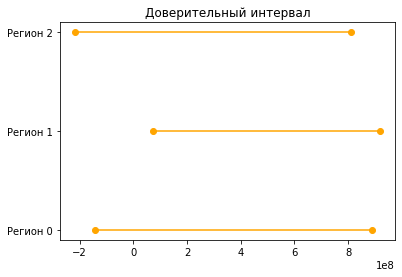

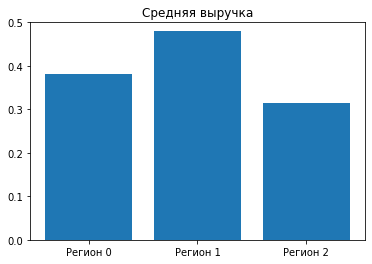

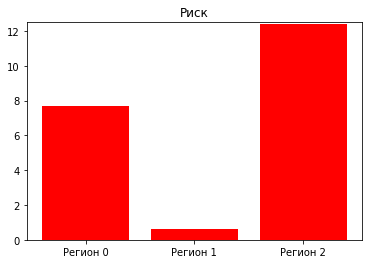

In [31]:
data_dict = {}
data_dict['region'] = ['Регион 0','Регион 1','Регион 2']
data_dict['lower'] = [lower_0,lower_1,lower_2]
data_dict['upper'] = [upper_0,upper_1,upper_2]
data_dict['mean'] = [mean_0 / 10**9, mean_1 / 10**9, mean_2 / 10**9]
data_dict['risk'] = [risk_0,risk_1,risk_2]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    plt.plot((lower,upper),(y,y),'ro-',color='orange')
plt.yticks(range(len(dataset)),list(dataset['region']))
plt.title('Доверительный интервал')
plt.show();

plt.bar(data_dict['region'],data_dict['mean'])
plt.ylim(0.0,0.5)
plt.title('Средняя выручка')
plt.show();

plt.bar(data_dict['region'],data_dict['risk'],color='red')
plt.ylim(0,12.5)
plt.title('Риск')
plt.show();

Построим распределение выборочных прибылей

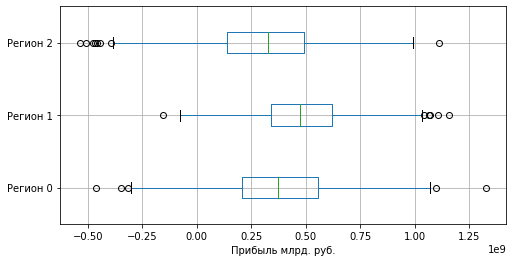

In [32]:
profits = pd.DataFrame({'Регион 0':profit_0, 'Регион 1':profit_1, 'Регион 2':profit_2} )
profits.plot.box(vert=False, figsize=(8, 4), grid=True);
plt.xlabel('Прибыль млрд. руб.')
plt.show();

Регион 1 является абсолютным победителем по значению средней выручки, риска и границам доверительного интервала. <br /> 
Только в Регионе 1 нижняя граница доверительного интервала болше нуля. <br /> 
Как видно по ящикам, граница усов у Региона 1 всё же меньше 0 и есть отрицательный выброс. Однако риск получить убыток всего 0.6%. <br /> 
В Регионе 0 есть выброс выше 1.25 млрд., однако риски получить убыток слишком велики. Вряд ли нам удастся случайно найти высокую прибыль.

## Вывод

**Подготовка данных**    
Данные без пропусков и выбросов. Явных дубликатов нет, несколько дубликатов id удалены.   
Параметр f2 сильно коррелирует с целевым признаком. А в регионе 1 корреляция почти 100%  
***
**Обучение и проверка модели**  
Из-за сильной корреляции целевого параметра с признаком f2 в регионе 1 модель получила очень хорошие показатели: R2 = 0.9996  
В регионе 0 и 2 показатели значительно хуже: R2 = 0.272, R2 = 0.196 соответственно.    

Однако среднее количество сырья в первом регионе наименьшее: всего 69    .2.
В регионе 0 и 2 среднее значение значительно выше и почти одинаковое: 92.8 и 94.5 соответственно.    
***
**Расчёт рисков**  
Регион: 0  
Средняя выручка: 0.38 млрд. руб.  
95%-й доверительный интервал: -0.143 - 0.891 млрд. руб.  
Риск: 7.7 %  

Регион: 1  
Средняя выручка: 0.48 млрд. руб.  
95%-й доверительный интервал: 0.074 - 0.918 млрд. руб.  
Риск: 0.6 %  

Регион: 2  
Средняя выручка: 0.32 млрд. руб.  
95%-й доверительный интервал: -0.216 - 0.811 млрд. руб.  
Риск: 12.4 %  

Регион 1 является абсолютным победителем по значению средней выручки, риска и границам доверительного интервала.
Только в Регионе 1 нижняя граница доверительного интервала болше нуля.  
***
**Итог**  
**Регион 1** самый перспективный для разработки.